In [3]:
!pip install graphiti-core langchain-google-genai langgraph langchain_core ipywidgets

In [4]:
import asyncio
import json
import logging
import os
import sys
import uuid
from contextlib import suppress
from datetime import datetime, timezone
from pathlib import Path
from typing import Annotated

import ipywidgets as widgets
from dotenv import load_dotenv
from IPython.display import Image, display
from typing_extensions import TypedDict

from graphiti_core import Graphiti
from graphiti_core.edges import EntityEdge
from graphiti_core.nodes import EpisodeType

from graphiti_core.utils.maintenance.graph_data_operations import clear_data
from graphiti_core.search.search_config_recipes import NODE_HYBRID_SEARCH_EPISODE_MENTIONS

from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
load_dotenv()

True

In [5]:
def setup_logging():
    logger = logging.getLogger()
    logger.setLevel(logging.ERROR)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    return logger

In [ ]:
# Configure Graphiti

neo4j_uri = os.environ.get('NEO4J_URI', 'bolt://localhost:7687')
neo4j_user = os.environ.get('NEO4J_USER', 'neo4j')
neo4j_password = os.environ.get('NEO4J_PASSWORD', 'Password')

client = Graphiti(
    neo4j_uri,
    neo4j_user,
    neo4j_password,
)

try:
    await client.build_indices_and_constraints()
    print("Successfully created indices")
except Exception as e:
    print(f"Failed to create indices: {e}")

Transaction failed and will be retried in 0.8167867837723163s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 111] Connect call failed ('::1', 7687, 0, 0))
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connect call failed ('127.0.0.1', 7687)))
Transaction failed and will be retried in 1.0858674721551709s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 111] Connect call failed ('::1', 7687, 0, 0))
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connect call failed ('127.0.0.1', 7687)))
Transaction failed and will be retried in 1.0236573443152224s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establ

Failed to create indices: Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 111] Connect call failed ('::1', 7687, 0, 0))
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connect call failed ('127.0.0.1', 7687))


Transaction failed and will be retried in 0.8490449001556966s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 111] Connect call failed ('::1', 7687, 0, 0))
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connect call failed ('127.0.0.1', 7687)))
Transaction failed and will be retried in 2.151256339926299s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 111] Connect call failed ('::1', 7687, 0, 0))
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connect call failed ('127.0.0.1', 7687)))
Transaction failed and will be retried in 1.087671940232734s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establis

In [9]:
async def ingest_products_data(client: Graphiti):
    script_dir = Path.cwd().parent
    json_file_path = script_dir / 'GRAPHTI' / 'manybirds_products.json'

    with open(json_file_path) as file:
        products = json.load(file)['products']

    for i, product in enumerate(products):
        await client.add_episode(
            name=product.get('title', f'Product {i}'),
            episode_body=str({k: v for k, v in product.items() if k != 'images'}),
            source_description='ManyBirds products',
            source=EpisodeType.json,
            reference_time=datetime.now(timezone.utc),
        )


await ingest_products_data(client)

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/Daily-Task/Agentic-AI/GRAPHTI/manybirds_products.json'

In [ ]:
user_name = 'jess'

await client.add_episode(
    name='User Creation',
    episode_body=(f'{user_name} is interested in buying a pair of shoes'),
    source=EpisodeType.text,
    reference_time=datetime.now(timezone.utc),
    source_description='SalesBot',
)

# let's get Jess's node uuid
nl = await client._search(user_name, NODE_HYBRID_SEARCH_EPISODE_MENTIONS)

user_node_uuid = nl.nodes[0].uuid

# and the ManyBirds node uuid
nl = await client._search('ManyBirds', NODE_HYBRID_SEARCH_EPISODE_MENTIONS)
manybirds_node_uuid = nl.nodes[0].uuid

NameError: name 'client' is not defined

In [10]:
def edges_to_facts_string(entities: list[EntityEdge]):
    return '-' + '\n- '.join([edge.fact for edge in entities])

In [11]:
@tool
async def get_shoe_data(query: str) -> str:
    """Search the graphiti graph for information about shoes"""
    edge_results = await client.search(
        query,
        center_node_uuid=manybirds_node_uuid,
        num_results=10,
    )
    return edges_to_facts_string(edge_results)


tools = [get_shoe_data]
tool_node = ToolNode(tools)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0).bind_tools(tools)
await tool_node.ainvoke({'messages': [await llm.ainvoke('wool shoes')]})

{'messages': [ToolMessage(content='Error: NameError("name \'manybirds_node_uuid\' is not defined")\n Please fix your mistakes.', name='get_shoe_data', tool_call_id='04dd489f-b8ee-4c48-b53a-8e0fee11f00f', status='error')]}

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_name: str
    user_node_uuid: str


async def chatbot(state: State):
    facts_string = None
    if len(state['messages']) > 0:
        last_message = state['messages'][-1]
        graphiti_query = f'{"SalesBot" if isinstance(last_message, AIMessage) else state["user_name"]}: {last_message.content}'
        # search graphiti using Jess's node uuid as the center node
        # graph edges (facts) further from the Jess node will be ranked lower
        edge_results = await client.search(
            graphiti_query, center_node_uuid=state['user_node_uuid'], num_results=5
        )
        facts_string = edges_to_facts_string(edge_results)

    system_message = SystemMessage(
        content=f"""You are a skillfull shoe salesperson working for ManyBirds. Review information about the user and their prior conversation below and respond accordingly.
        Keep responses short and concise. And remember, always be selling (and helpful!)

        Things you'll need to know about the user in order to close a sale:
        - the user's shoe size
        - any other shoe needs? maybe for wide feet?
        - the user's preferred colors and styles
        - their budget

        Ensure that you ask the user for the above if you don't already know.

        Facts about the user and their conversation:
        {facts_string or 'No facts about the user and their conversation'}"""
    )

    messages = [system_message] + state['messages']

    response = await llm.ainvoke(messages)

    # add the response to the graphiti graph.
    # this will allow us to use the graphiti search later in the conversation
    # we're doing async here to avoid blocking the graph execution
    asyncio.create_task(
        client.add_episode(
            name='Chatbot Response',
            episode_body=f'{state["user_name"]}: {state["messages"][-1]}\nSalesBot: {response.content}',
            source=EpisodeType.message,
            reference_time=datetime.now(timezone.utc),
            source_description='Chatbot',
        )
    )

    return {'messages': [response]}

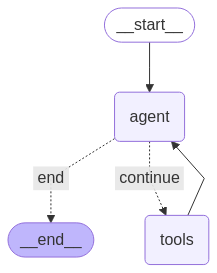

In [13]:
graph_builder = StateGraph(State)

memory = MemorySaver()


# Define the function that determines whether to continue or not
async def should_continue(state, config):
    messages = state['messages']
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return 'end'
    # Otherwise if there is, we continue
    else:
        return 'continue'


graph_builder.add_node('agent', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', should_continue, {'continue': 'tools', 'end': END})
graph_builder.add_edge('tools', 'agent')

graph = graph_builder.compile(checkpointer=memory)
with suppress(Exception):
    display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
await graph.ainvoke(
    {
        'messages': [
            {
                'role': 'user',
                'content': 'What sizes do the TinyBirds Wool Runners in Natural Black come in?',
            }
        ],
        'user_name': user_name,
        'user_node_uuid': user_node_uuid,
    },
    config={'configurable': {'thread_id': uuid.uuid4().hex}},
)

In [ ]:
conversation_output = widgets.Output()
config = {'configurable': {'thread_id': uuid.uuid4().hex}}
user_state = {'user_name': user_name, 'user_node_uuid': user_node_uuid}


async def process_input(user_state: State, user_input: str):
    conversation_output.append_stdout(f'\nUser: {user_input}\n')
    conversation_output.append_stdout('\nAssistant: ')

    graph_state = {
        'messages': [{'role': 'user', 'content': user_input}],
        'user_name': user_state['user_name'],
        'user_node_uuid': user_state['user_node_uuid'],
    }

    try:
        async for event in graph.astream(
            graph_state,
            config=config,
        ):
            for value in event.values():
                if 'messages' in value:
                    last_message = value['messages'][-1]
                    if isinstance(last_message, AIMessage) and isinstance(
                        last_message.content, str
                    ):
                        conversation_output.append_stdout(last_message.content)
    except Exception as e:
        conversation_output.append_stdout(f'Error: {e}')


def on_submit(b):
    user_input = input_box.value
    input_box.value = ''
    asyncio.create_task(process_input(user_state, user_input))


input_box = widgets.Text(placeholder='Type your message here...')
submit_button = widgets.Button(description='Send')
submit_button.on_click(on_submit)

conversation_output.append_stdout('Asssistant: Hello, how can I help you find shoes today?')

display(widgets.VBox([input_box, submit_button, conversation_output]))